Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/ml-frameworks/using-mlflow/train-and-deploy-pytorch/train-and-deploy-pytorch.png)

# Use MLflow with Azure Machine Learning to Train and Deploy PyTorch Image Classifier

This example shows you how to use MLflow together with Azure Machine Learning services for tracking the metrics and artifacts while training a PyTorch model to classify MNIST digit images and deploy the model  as a web service. You'll learn how to:

 1. Set up MLflow tracking URI so as to use Azure ML
 2. Create experiment
 3. Instrument your model with MLflow tracking
 4. Train a PyTorch model locally
 5. Train a model on GPU compute on Azure
 6. View your experiment within your Azure ML Workspace in Azure Portal
 7. Deploy the model as a web service on Azure Container Instance
 8. Call the model to make predictions
 
## Pre-requisites
 
If you are using a Notebook VM, you are all set. Otherwise, go through the [Configuration](../../../../configuration.ipnyb) notebook to set up your Azure Machine Learning workspace and ensure other common prerequisites are met.

Install PyTorch, this notebook has been tested with torch==1.4

Also, install azureml-mlflow package using ```pip install azureml-mlflow```. Note that azureml-mlflow installs mlflow package itself as a dependency if you haven't done so previously.

## Set-up

Import packages and check versions of Azure ML SDK and MLflow installed on your computer. Then connect to your Workspace.

In [0]:
pip install azureml-sdk[notebooks] torch torchvision azureml-mlflow

Python interpreter will be restarted.
Requirement already satisfied: azureml-sdk[notebooks] in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (1.17.0)
Requirement already satisfied: torch in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (1.7.0)
Collecting torchvision
 Downloading torchvision-0.8.1-cp37-cp37m-manylinux1_x86_64.whl (12.7 MB)
Requirement already satisfied: azureml-mlflow in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (1.17.0.post1)
Requirement already satisfied: azureml-train~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-pipeline~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-dataset-runtime[fuse]~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-train-automl-client~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-core~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-widgets~=1.17.0; extra == "notebooks" in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-contrib-notebook~=1.17.0; extra == "notebooks" in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: typing-extensions in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from torch) (3.7.4.3)
Requirement already satisfied: future in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from torch) (0.18.2)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from torch) (1.18.1)
Requirement already satisfied: dataclasses in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from torch) (0.6)
Collecting pillow>=4.1.1
 Downloading Pillow-8.0.1-cp37-cp37m-manylinux1_x86_64.whl (2.2 MB)
Requirement already satisfied: mlflow>=1.0.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-mlflow) (1.11.0)
Requirement already satisfied: jsonpickle in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-mlflow) (1.4.1)
Requirement already satisfied: azureml-train-core~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-train~=1.17.0->azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-pipeline-core~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-pipeline~=1.17.0->azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: azureml-pipeline-steps~=1.17.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages (from azureml-pipeline~=1.17.0->azureml-sdk[notebooks]) (1.17.0)
Requirement already satisfied: pyarrow<2.0.0,>=

In [0]:
import sys, os
import mlflow
import mlflow.azureml

import azureml.core
from azureml.core import Workspace


print("SDK version:", azureml.core.VERSION)
print("MLflow version:", mlflow.version.VERSION)

SDK version: 1.17.0
MLflow version: 1.11.0

In [0]:
ws = Workspace.from_config()
ws.get_details()

Out[9]: {'id': '/subscriptions/d30d76c0-804c-4f4e-ab7b-509d06a49550/resourceGroups/vlk-workshop/providers/Microsoft.MachineLearningServices/workspaces/vlk-workspace',
 'name': 'vlk-workspace',
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': 'f89c9046-4c5e-495d-b4f6-977a78dd3507',
 'description': '',
 'friendlyName': 'vlk-workspace',
 'creationTime': '2020-11-02T09:33:19.3102244+00:00',
 'containerRegistry': '/subscriptions/d30d76c0-804c-4f4e-ab7b-509d06a49550/resourceGroups/vlk-workshop/providers/Microsoft.ContainerRegistry/registries/f89c90464c5e495db4f6977a78dd3507',
 'keyVault': '/subscriptions/d30d76c0-804c-4f4e-ab7b-509d06a49550/resourcegroups/vlk-workshop/providers/microsoft.keyvault/vaults/vlkworkspace0955496220',
 'applicationInsights': '/subscriptions/d30d76c0-804c-4f4e-ab7b-509d06a49550/resourcegroups/vlk-workshop/providers/microsoft.insights/components/vlkworkspace7514099320',
 'identityPrincipalId': '3d10a8cd-ecc1-4b0f-ab4a-788df3d3cb2d',
 'identityTenantId': '72f988bf-86f1-41af-91ab-2d7cd011db47',
 'identityType': 'SystemAssigned',
 'storageAccount': '/subscriptions/d30d76c0-804c-4f4e-ab7b-509d06a49550/resourcegroups/vlk-workshop/providers/microsoft.storage/storageaccounts/vlkworkspace8006493384',
 'hbiWorkspace': False,
 'discoveryUrl': 'https://westeurope.experiments.azureml.net/discovery',
 'notebookInfo': {'fqdn': 'ml-vlk-workspac-westeurope-f89c9046-4c5e-495d-b4f6-977a78dd3507.notebooks.azure.net',
 'resource_id': '342b11ba229b48279b092c1c0ff03cdd'}}

## Set tracking URI

Set the MLflow tracking URI to point to your Azure ML Workspace. The subsequent logging calls from MLflow APIs will go to Azure ML services and will be tracked under your Workspace.

In [0]:
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

## Create Experiment

In both MLflow and Azure ML, training runs are grouped into experiments. Let's create one for our experimentation.

In [0]:
experiment_name = "pytorch-with-mlflow"
mlflow.set_experiment(experiment_name)

## Train model locally while logging metrics and artifacts

The ```scripts/train.py``` program contains the code to load the image dataset, train and test the model. Within this program, the train.driver function wraps the end-to-end workflow.

Within the driver, the ```mlflow.start_run``` starts MLflow tracking. Then, ```mlflow.log_metric``` functions are used to track the convergence of the neural network training iterations. Finally ```mlflow.pytorch.save_model``` is used to save the trained model in framework-aware manner.

Let's add the program to search path, import it as a module and invoke the driver function. Note that the training can take few minutes.

In [0]:
%%writefile /dbfs/scripts/train.py

# Copyright (c) 2017, PyTorch Team
# All rights reserved
# Licensed under BSD 3-Clause License.

# This example is based on PyTorch MNIST example:
# https://github.com/pytorch/examples/blob/master/mnist/main.py

import mlflow
import mlflow.pytorch
from mlflow.utils.environment import _mlflow_conda_env
import warnings
import cloudpickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # Added the view for reshaping score requests
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            # Use MLflow logging
            mlflow.log_metric("epoch_loss", loss.item())


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print("\n")
    print("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # Use MLflow logging
    mlflow.log_metric("average_loss", test_loss)


class Args(object):
    pass


# Training settings
args = Args()
setattr(args, 'batch_size', 64)
setattr(args, 'test_batch_size', 1000)
setattr(args, 'epochs', 3)  # Higher number for better convergence
setattr(args, 'lr', 0.01)
setattr(args, 'momentum', 0.5)
setattr(args, 'no_cuda', True)
setattr(args, 'seed', 1)
setattr(args, 'log_interval', 10)
setattr(args, 'save_model', True)

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


def driver():
    warnings.filterwarnings("ignore")
    # Dependencies for deploying the model
    pytorch_index = "https://download.pytorch.org/whl/"
    pytorch_version = "cpu/torch-1.1.0-cp36-cp36m-linux_x86_64.whl"
    deps = [
        "cloudpickle=={}".format(cloudpickle.__version__),
        pytorch_index + pytorch_version,
        "torchvision=={}".format(torchvision.__version__),
        "Pillow=={}".format("6.0.0")
    ]
    with mlflow.start_run() as run:
        model = Net().to(device)
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum)
        for epoch in range(1, args.epochs + 1):
            train(args, model, device, train_loader, optimizer, epoch)
            test(args, model, device, test_loader)
        # Log model to run history using MLflow
        if args.save_model:
            model_env = _mlflow_conda_env(additional_pip_deps=deps)
            mlflow.pytorch.log_model(model, "model", conda_env=model_env)
    return run


if __name__ == "__main__":
    driver()

Writing /dbfs/scripts/train.py

In [0]:
import os
import sys 

lib_path = os.path.abspath("/dbfs/scripts/")
sys.path.append(lib_path)

import train


Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ../data/MNIST/raw/train-images-idx3-ubyte.gz
0it [00:00, ?it/s] 0%| | 0/9912422 [00:00<?, ?it/s] 0%| | 16384/9912422 [00:00<01:06, 149311.62it/s] 1%| | 98304/9912422 [00:00<00:50, 192690.05it/s] 4%|▍ | 434176/9912422 [00:00<00:35, 265935.22it/s] 18%|█▊ | 1753088/9912422 [00:00<00:21, 375407.88it/s] 57%|█████▋ | 5619712/9912422 [00:00<00:08, 533220.70it/s] 94%|█████████▎| 9281536/9912422 [00:01<00:00, 756692.99it/s]Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw
Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ../data/MNIST/raw/train-labels-idx1-ubyte.gz

0it [00:00, ?it/s]
 0%| | 0/28881 [00:00<?, ?it/s]Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw
Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

 0%| | 0/1648877 [00:00<?, ?it/s]

 3%|▎ | 49152/1648877 [00:00<00:05, 277153.89it/s]

 13%|█▎ | 212992/1648877 [00:00<00:04, 354982.51it/s]

 53%|█████▎ | 876544/1648877 [00:00<00:01, 489553.46it/s]Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz



0it [00:00, ?it/s]


 0%| | 0/4542 [00:00<?, ?it/s]Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
/local_disk0/.ephemeral_nfs/envs/pythonEnv-bdc6927b-e4b7-4258-b06d-f395aecd16bd/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
 return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Done!

In [0]:
run = train.driver()

9920512it [00:18, 529867.95it/s] 
32768it [00:17, 1906.55it/s] 
1654784it [00:16, 97911.29it/s] 
8192it [00:16, 508.55it/s] 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292215
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.237175
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.144639
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.066939
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.848372
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.467213
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.053226
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.861491
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.887124
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.555712
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.459148
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.734666
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.798494
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.488349
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.375467
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.284122
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.397119
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.493054
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.293963
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.228800
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.374828
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.400673
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.188950
Train Epoch: 1 [14720/60000 (25%)]	Loss: 0.521487
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.308290
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.305286
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.317441
Train Epoch: 1 [17280/60000 (29%)]	Loss: 0.274451
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.292993
Train Epoch: 1 [18560/60000 (31%)]	Loss: 0.244225
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.317493
Train Epoch: 1 [19840/60000 (33%)]	Loss: 0.209813
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.197855
Train Epoch: 1 [21120/60000 (35%)]	Loss: 0.292968
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.144607
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.306008
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.165458
Train Epoch: 1 [23680/60000 (39%)]	Loss: 0.249060
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.201530
Train Epoch: 1 [24960/60000 (42%)]	Loss: 0.173195
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.213637
Train Epoch: 1 [26240/60000 (44%)]	Loss: 0.330276
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.161839
Train Epoch: 1 [27520/60000 (46%)]	Loss: 0.258197
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.180711
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.273772
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.089628
Train Epoch: 1 [30080/60000 (50%)]	Loss: 0.148503
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.216951
Train Epoch: 1 [31360/60000 (52%)]	Loss: 0.167481
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.257101
Train Epoch: 1 [32640/60000 (54%)]	Loss: 0.122050
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.100812
Train Epoch: 1 [33920/60000 (57%)]	Loss: 0.176560
Train Epoch: 1 [34560/60000 (58%)]	Loss: 0.150439
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.223365
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.156756
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.173683
Train Epoch: 1 [37120/60000 (62%)]	Loss: 0.114064
Train Epoch: 1 [37760/60000 (63%)]	Loss: 0.231632
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.070759
Train Epoch: 1 [39040/60000 (65%)]	Loss: 0.135264
Train Epoch: 1 [39680/60000 (66%)]	Loss: 0.225395
Train Epoch: 1 [40320/60000 (67%)]	Loss: 0.375163
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.256636
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.204818
Train Epoch: 1 [42240/60000 (70%)]	Loss: 0.153233
Train Epoch: 1 [42880/60000 (71%)]	Loss: 0.121430
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.089784
Train Epoch: 1 [44160/60000 (74%)]	Loss: 0.074963
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.087582
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.062373
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.098643
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.212868
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.096654
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.084110
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.077203
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.073826
T

### Train model on GPU compute on Azure

Next, let's run the same script on GPU-enabled compute for faster training. If you've completed the the [Configuration](../../../configuration.ipnyb) notebook, you should have a GPU cluster named "gpu-cluster" available in your workspace. Otherwise, follow the instructions in the notebook to create one. For simplicity, this example uses single process on single VM to train the model.

Clone an environment object from the PyTorch 1.4 Azure ML curated environment. Azure ML curated environments are pre-configured environments to simplify ML setup, reference [this doc](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments#use-a-curated-environment) for more information. To enable MLflow tracking, add ```azureml-mlflow``` as pip package.

In [0]:
from azureml.core import Environment

env = Environment.get(workspace=ws, name="AzureML-PyTorch-1.4-GPU").clone("mlflow-env")

env.python.conda_dependencies.add_pip_package("azureml-mlflow")
env.python.conda_dependencies.add_pip_package("Pillow==6.0.0")

Create a ScriptRunConfig to specify the training configuration: script, compute as well as environment.

In [0]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory="/dbfs/scripts", script="train.py")
src.run_config.environment = env
src.run_config.target = "gpu-cluster"

Get a reference to the experiment you created previously, but this time, as an Azure Machine Learning experiment object.

Then, use the ```Experiment.submit``` method to start the remote training run. Note that the first training run often takes longer as Azure Machine Learning service builds the Docker image for executing the script. Subsequent runs will be faster as the cached image is used.

In [0]:
from azureml.core import Experiment
exp = Experiment(ws, experiment_name)
run = exp.submit(src)

You can monitor the run and its metrics on Azure Portal.

In [0]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
pytorch-with-mlflow,pytorch-with-mlflow_1604322731_4bfb7707,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


Also, you can wait for run to complete.

In [0]:
run.wait_for_completion(show_output=True)

RunId: pytorch-with-mlflow_1604322731_4bfb7707
Web View: https://ml.azure.com/experiments/pytorch-with-mlflow/runs/pytorch-with-mlflow_1604322731_4bfb7707?wsid=/subscriptions/d30d76c0-804c-4f4e-ab7b-509d06a49550/resourcegroups/vlk-workshop/workspaces/vlk-workspace

Streaming azureml-logs/20_image_build_log.txt
=============================================

2020/11/02 13:12:18 Downloading source code...
2020/11/02 13:12:20 Finished downloading source code
2020/11/02 13:12:20 Creating Docker network: acb_default_network, driver: 'bridge'
2020/11/02 13:12:21 Successfully set up Docker network: acb_default_network
2020/11/02 13:12:21 Setting up Docker configuration...
2020/11/02 13:12:22 Successfully set up Docker configuration
2020/11/02 13:12:22 Logging in to registry: f89c90464c5e495db4f6977a78dd3507.azurecr.io
2020/11/02 13:12:23 Successfully logged into f89c90464c5e495db4f6977a78dd3507.azurecr.io
2020/11/02 13:12:23 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2020/11/02 13:12:23 Scanning for dependencies...
2020/11/02 13:12:24 Successfully scanned dependencies
2020/11/02 13:12:24 Launching container with name: acb_step_0
Sending build context to Docker daemon 60.93kB

Step 1/15 : FROM mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04:20201019.v1@sha256:26ae826fa7649a3ea62483e32a60336146fa39c5add2d129354ab3b9739a4054
sha256:26ae826fa7649a3ea62483e32a60336146fa39c5add2d129354ab3b9739a4054: Pulling from azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04
171857c49d0f: Pulling fs layer
419640447d26: Pulling fs layer
61e52f862619: Pulling fs layer
c118dad7e37a: Pulling fs layer
2e36372995f9: Pulling fs layer
0b8e00a4ba4e: Pulling fs layer
b3026b4f2581: Pulling fs layer
93cc193ccd98: Pulling fs layer
ee06e59a4314: Pulling fs layer
b0ac690bb2f2: Pulling fs layer
5f11ace0944e: Pulling fs layer
d4e18c29e104: Pulling fs layer
09ba06861fca: Pulling fs layer
83213e0b5131: Pulling fs layer
7b0feb8d64db: Pulling fs layer
7b0b507bb1e9: Pulling fs layer
94e0f0e2d7da: Pulling fs layer
45b4bc5400c1: Pulling fs layer
30f9a1497794: Pulling fs layer
c118dad7e37a: Waiting
2e36372995f9: Waiting
0b8e00a4ba4e: Waiting
b3026b4f2581: Waiting
93cc193ccd98: Waiting
ee06e59a4314: Waiting
b0ac690bb2f2: Waiting
5f11ace0944e: Waiting
d4e18c29e104: Waiting
09ba06861fca: Waiting
83213e0b5131: Waiting
7b0feb8d64db: Waiting
7b0b507bb1e9: Waiting
94e0f0e2d7da: Waiting
45b4bc5400c1: Waiting
30f9a1497794: Waiting
61e52f862619: Verifying Checksum
61e52f862619: Download complete
419640447d26: Verifying Checksum
419640447d26: Download complete
c118dad7e37a: Verifying Checksum
c118dad7e37a: Download complete
0b8e00a4ba4e: Verifying Checksum
0b8e00a4ba4e: Download complete
2e36372995f9: Verifying Checksum
2e36372995f9: Download complete
171857c49d0f: Verifying Checksum
171857c49d0f: Download complete
93cc193ccd98: Verifying Checksum
93cc193ccd98: Download complete
b0ac690bb2f2: Verifying Checksum
b0ac690bb2f2: Download complete
171857c49d0f: Pull complete
419640447d26: Pull complete
61e52f862619: Pull complete
c118dad7e37a: Pull complete
2e36372995f9: Pull complete
0b8e00a4ba4e: Pull complete
5f11ace0944e: Verifying Checksum
5f11ace0944e: Download complete
d4e18c29e104: Verifying Checksum
d4e18c29e104: Download complete
b3026b4f2581: Verifying Checksum
b3026b4f2581: Download complete
ee06e59a4314: Verifying Checksum
ee06e59a4314: Download complete
09ba06861fca: Verifying Checksum
09ba06861fca: Download complete
83213e0b5131: Verifying Checksum
83213e0b5131: Download complete
7b0b507bb1e9: Verifying Checksum
7b0b507bb1e9: Download complete
94e0f0e2d7da: Verifying Checksum
94e0f0e2d7da: Download complete
45b4bc5400c1: Verifying Checksum
45b4bc5400c1: Download complete
30f9a1497794: Verifying Checksum
30f9a1497794: Download complete
7b0feb8d64db: Verifying Checksum
7b0feb8d64db: Download complete
b3026b4f2581: Pull complete
93cc193ccd98: Pull complete

ee06e59a4314: Pull complete
b0ac690bb2f2: Pull 

## Deploy model as web service

The ```mlflow.azureml.deploy``` function registers the logged PyTorch model and deploys the model in a framework-aware manner. It automatically creates the PyTorch-specific inferencing wrapper code and specifies package dependencies for you. See [this doc](https://mlflow.org/docs/latest/models.html#id34) for more information on deploying models on Azure ML using MLflow.

In this example, we deploy the Docker image to Azure Container Instance: a serverless compute capable of running a single container. You can tag and add descriptions to help keep track of your web service. 

[Other inferencing compute choices](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where) include Azure Kubernetes Service which provides scalable endpoint suitable for production use.

Note that the service deployment can take several minutes.

In [0]:
from azureml.core.webservice import AciWebservice, Webservice

model_path = "model"

aci_config = AciWebservice.deploy_configuration(cpu_cores=2, 
                                                memory_gb=5, 
                                                tags={"data": "MNIST",  "method" : "pytorch"}, 
                                                description="Predict using webservice")

webservice, azure_model = mlflow.azureml.deploy(model_uri='runs:/{}/{}'.format(run.id, model_path),
                                                      workspace=ws,
                                                      deployment_config=aci_config,
                                                      service_name="pytorch-mnist-1",
                                                      model_name="pytorch_mnist")

Registering model pytorch_mnist
2020/11/02 13:51:02 INFO mlflow.azureml: Registered an Azure Model with name: `pytorch_mnist` and version: `1`
2020/11/02 13:51:45 INFO mlflow.azureml: Deploying an Azure Webservice with name: `pytorch-mnist-1`
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running........................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"

Once the deployment has completed you can check the scoring URI of the web service.

In [0]:
print("Scoring URI is: {}".format(webservice.scoring_uri))

Scoring URI is: http://12048ed0-c17c-4e63-be25-e664cbb8600e.westus.azurecontainer.io/score

In case of a service creation issue, you can use ```webservice.get_logs()``` to get logs to debug.

## Make predictions using a web service

To make the web service, create a test data set as normalized PyTorch tensors. 

Then, let's define a utility function that takes a random image and converts it into a format and shape suitable for input to the PyTorch inferencing end-point. The conversion is done by: 

 1. Select a random (image, label) tuple
 2. Take the image and converting the tensor to NumPy array 
 3. Reshape array into 1 x 1 x N array
    * 1 image in batch, 1 color channel, N = 784 pixels for MNIST images
    * Note also ```x = x.view(-1, 1, 28, 28)``` in net definition in ```train.py``` program to shape incoming scoring requests.
 4. Convert the NumPy array to list to make it into a built-in type.
 5. Create a dictionary {"data", &lt;list&gt;} that can be converted to JSON string for web service requests.

In [0]:
from torchvision import datasets, transforms
import random
import numpy as np

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))]))


def get_random_image():
    image_idx = random.randint(0,len(test_data))
    image_as_tensor = test_data[image_idx][0]
    return {"data": elem for elem in image_as_tensor.numpy().reshape(1,1,-1).tolist()}

Then, invoke the web service using a random test image. Convert the dictionary containing the image to JSON string before passing it to web service.

The response contains the raw scores for each label, with greater value indicating higher probability. Sort the labels and select the one with greatest score to get the prediction. Let's also plot the image sent to web service for comparison purposes.

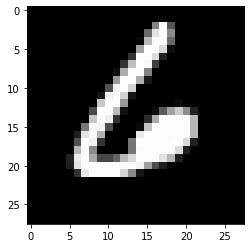

In [0]:
%matplotlib inline

import json
import matplotlib.pyplot as plt

test_image = get_random_image()

response = webservice.run(json.dumps(test_image))

response = sorted(response[0].items(), key = lambda x: x[1], reverse = True)


print("Predicted label:", response[0][0])
plt.imshow(np.array(test_image["data"]).reshape(28,28), cmap = "gray")

You can also call the web service using a raw POST method against the web service

In [0]:
import requests

response = requests.post(url=webservice.scoring_uri, data=json.dumps(test_image),headers={"Content-type": "application/json"})
print(response.text)

[{"0": -9.258138656616211, "1": -14.588045120239258, "2": -10.144003868103027, "3": -16.533933639526367, "4": -9.56055736541748, "5": -14.168560981750488, "6": -0.00020694732666015625, "7": -20.93991470336914, "8": -15.089753150939941, "9": -17.592388153076172}]

## Clean up
You can delete the ACI deployment with a delete API call.

In [0]:
webservice.delete()